In [1]:
# https://www.kaggle.com/datasets/joyshil0599/abilify-oral-reviews-dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [3]:
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

In [4]:
corpus = pd.read_csv('/kaggle/input/abilify-oral-reviews-dataset/abilify_ora_effected_peple_reviewl.csv', encoding_errors='replace') # use replacement character for characters not in UTF-8
corpus.head(5)

,Time of Meditation,Suspect name,Age,Gender,Suspect Status,Date,Condition,overall-rating,description-text
0,2 to less than 5 years,Barbara,65-74,Female,Patient,2/13/2023,Bipolar Disorder in Remission,5.0,I've taken Abilify to augment bupropion for Bi...
1,1 to 6 months,Matt,35-44,Male,Patient,2/9/2023,Schizophrenia,2.0,Worked for 3 months. Waste of time. You think ...
2,1 to 6 months,Alex Adams,25-34,Male,Patient,1/5/2023,Schizophrenia,2.3,Worked really well for like 2 months then I go...
3,1 to less than 2 years,Jill,35-44,Female,Patient,12/28/2022,Additional Medications to Treat Depression,1.0,This is the worst drug on the market. It cause...
4,1 to 6 months,Anonymous,45-54,Female,Patient,12/7/2022,Additional Medications to Treat Depression,2.0,I was prescribed as a child at 15 years old. I...


In [5]:
corpus = corpus[['overall-rating', 'description-text']]
print(len(corpus))
corpus.head(5)

1835


,overall-rating,description-text
0,5.0,I've taken Abilify to augment bupropion for Bi...
1,2.0,Worked for 3 months. Waste of time. You think ...
2,2.3,Worked really well for like 2 months then I go...
3,1.0,This is the worst drug on the market. It cause...
4,2.0,I was prescribed as a child at 15 years old. I...


In [6]:
corpus = corpus.dropna(axis=0)
print(len(corpus))

1540


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


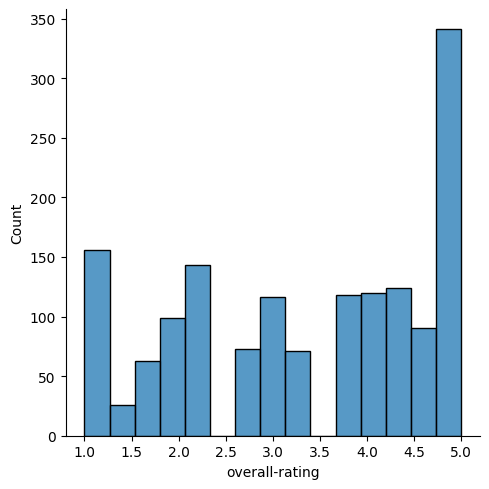

In [7]:
# fix histogram ticks
sns.displot(corpus, x='overall-rating', bins=15)

<Axes: xlabel='rating_rounded', ylabel='count'>

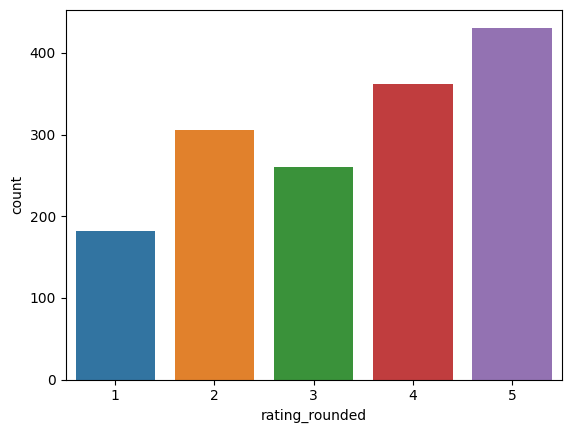

In [8]:
corpus['rating_rounded'] = corpus['overall-rating'].round().astype(int)
sns.countplot(corpus, x='rating_rounded')

In [9]:
# https://geeksforgeeks.org/python-word-embedding-using-word2vec/
# https://spotintelligence.com/2022/12/21/nltk-preprocessing-pipeline/

In [10]:
# make into sklearn pipeline

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens_lower = [token.lower() for token in tokens]
    tokens_no_punct = [token for token in tokens_lower if token not in string.punctuation]
    tokens_no_stopwords = [token for token in tokens_no_punct if token not in stopwords]
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens_no_stopwords]
    return tokens_lemmatized

In [11]:
corpus['text_preprocessed'] = corpus['description-text'].apply(preprocess_text)
corpus.head(5)

,overall-rating,description-text,rating_rounded,text_preprocessed
0,5.0,I've taken Abilify to augment bupropion for Bi...,5,"['ve, taken, abilify, augment, bupropion, bipo..."
1,2.0,Worked for 3 months. Waste of time. You think ...,2,"[worked, 3, month, waste, time, think, better,..."
2,2.3,Worked really well for like 2 months then I go...,2,"[worked, really, well, like, 2, month, got, re..."
3,1.0,This is the worst drug on the market. It cause...,1,"[worst, drug, market, caused, gain, 50, pound,..."
4,2.0,I was prescribed as a child at 15 years old. I...,2,"[prescribed, child, 15, year, old, caused, mus..."


In [20]:
from gensim.models import Word2Vec

data = corpus['text_preprocessed']
w2v_model = Word2Vec(data, min_count=10, vector_size=100, window=2)

In [21]:
len(data)

1540

In [22]:
def vectorize(words):
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [23]:
X_train_unvectorized = data[:1000]
X_test_unvectorized = data[1000:]

y_train = corpus['rating_rounded'][:1000]
y_test = corpus['rating_rounded'][1000:]

X_train = [vectorize(sentence) for sentence in X_train_unvectorized]
X_test = [vectorize(sentence) for sentence in X_test_unvectorized]

In [29]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=75, random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

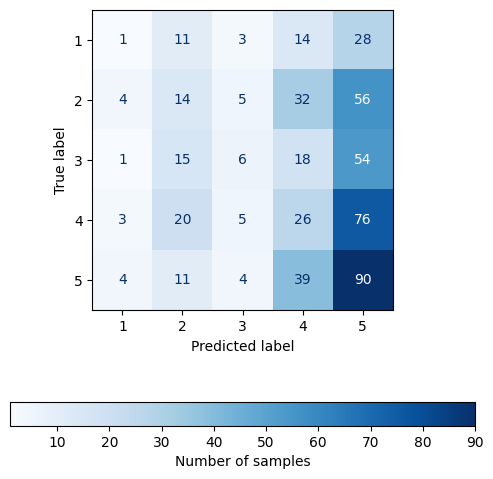

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=[1, 2, 3, 4, 5])
cm_plot.plot(cmap='Blues', ax=ax)
im = cm_plot.im_
im.colorbar.remove()
plt.colorbar(im, orientation='horizontal', pad=0.2, label='Number of samples')

plt.title('');